
# Aula 07 — MLP em NumPy (atividade resolvida)
**Objetivo:** implementar, do zero, uma MLP simples (1 camada oculta) para prever **propensão de compra** em um cenário didático, usando o dataset de clientes do Buonopreço.

> **O que você verá neste notebook**
> - Preparação dos dados (seleção de atributos, criação do alvo binário, padronização).
> - Implementação **na mão** de uma MLP com ReLU (oculta) + Sigmoid (saída).
> - Treinamento por **descida do gradiente**, curva de perda e avaliação com **matriz de confusão** e acurácia.


In [34]:
# =====================
# Configurações gerais
# =====================

data_path = "https://raw.githubusercontent.com/sousamaf/AI-Lab/main/datasets/dataset-buonopreco-registro_de_clientes.csv"
# data_path = "dataset-buonopreco-registro_de_clientes.csv"  # caso queira usar localmente

# Hiperparâmetros (ajuste e rode novamente)
HIDDEN_UNITS = 8      # neurônios na camada oculta
LEARNING_RATE = 0.05  # taxa de aprendizado (eta)
EPOCHS = 200          # número de épocas
TEST_SIZE = 0.2       # fração para teste
SEED = 42             # reprodutibilidade

# Regras para criação do alvo binário (fallbacks)
POSITIVE_CLASSES = {"Alto Valor Ticket Médio", "Fiel Econômico"}

# ---------------------
# Imports
# ---------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


np.random.seed(SEED)


In [35]:
# =====================
# Carregamento do dataset
# =====================

try:
    if data_path.startswith("http"):
        df = pd.read_csv(data_path)
        origem = "CSV do GitHub"
    elif os.path.exists(data_path):
        df = pd.read_csv(data_path)
        origem = "CSV local"
    else:
        raise FileNotFoundError("Dataset não encontrado.")
except Exception as e:
    print("Erro ao carregar o dataset:", e)

print("Dimensão:", df.shape)
print("Colunas:", list(df.columns))
print("\nAmostra:")
df.head()


Dimensão: (600, 10)
Colunas: ['cliente_id', 'idade', 'frequencia_mensal', 'gasto_medio', 'pct_compras_com_desconto', 'whatsapp_envios', 'whatsapp_respostas', 'categoria_preferida', 'taxa_resposta_whatsapp', 'classe_cliente']

Amostra:


,cliente_id,idade,frequencia_mensal,gasto_medio,pct_compras_com_desconto,whatsapp_envios,whatsapp_respostas,categoria_preferida,taxa_resposta_whatsapp,classe_cliente
0,C0017f4ca,41,1.09,420.34,16.7,5,3,Laticínios,0.60,Alto Valor Ticket Médio
1,C01418abf,53,1.06,343.02,5.6,2,1,Laticínios,0.50,Alto Valor Ticket Médio
2,C01f7a2b5,34,1.10,380.47,22.2,4,1,Laticínios,0.25,Alto Valor Ticket Médio
3,C02781890,36,1.18,305.87,11.1,1,0,Laticínios,0.00,Familiar Mensalista
4,C02adda22,49,1.02,366.82,17.6,4,2,Mercearia,0.50,Alto Valor Ticket Médio


In [36]:
# =====================
# Criação do alvo binário 'y' (versão com scikit-learn)
# =====================

from sklearn.preprocessing import LabelBinarizer

def infer_binary_target_sklearn(dataframe, positive_classes=("Alto Valor Ticket Médio", "Fiel Econômico")):
    """
    Retorna:
      X (pd.DataFrame): features sem a coluna-alvo
      y (np.ndarray, shape (n_samples,)): alvo binário {0,1}
      note (str): observação sobre como o alvo foi criado
    """
    df_ = dataframe.copy()

    # Caso 1: coluna 'compra' ou 'target' já binária
    for cand in ("compra", "target", "propenso_compra"):
        if cand in df_.columns:
            vals = df_[cand].dropna().unique()
            # usa LabelBinarizer para padronizar a saída {0,1} se já for binário ou boole
            if set(vals).issubset({0, 1}) or set(vals).issubset({0.0, 1.0}) or set(map(type, vals)) == {bool}:
                lb = LabelBinarizer()
                y = lb.fit_transform(df_[cand].astype(int).values).ravel()
                X = df_.drop(columns=[cand])
                return X, y, f"Alvo binário detectado em coluna '{cand}'."

    # Caso 2: coluna 'classe_cliente' (multiclasse) -> binariza por conjunto de classes positivas
    if "classe_cliente" in df_.columns:
        # máscara booleana para as classes positivas indicadas
        pos_mask = df_["classe_cliente"].astype(str).str.strip().isin(positive_classes)
        lb = LabelBinarizer()
        y = lb.fit_transform(pos_mask.astype(int).values).ravel()
        X = df_.drop(columns=["classe_cliente"])
        return X, y, "Alvo binário criado a partir de 'classe_cliente' (positivas = classes informadas)."

    # Caso 3: fallback didático — limiar em 'gasto_medio' ou 'frequencia_mensal'
    for cand, thresh in (("gasto_medio", 200.0), ("frequencia_mensal", 2.0)):
        if cand in df_.columns:
            # usa LabelBinarizer para garantir vetor 0/1
            lb = LabelBinarizer()
            y = lb.fit_transform((df_[cand].astype(float) >= thresh).astype(int).values).ravel()
            # remove a coluna usada para criar o alvo para evitar vazamento
            X = df_.drop(columns=[cand])
            return X, y, f"Alvo binário criado por limiar didático: {cand} >= {thresh}."

    raise ValueError("Não foi possível inferir um alvo binário. Ajuste a lógica conforme seu dataset.")

# Uso:
X_raw, y, target_note = infer_binary_target_sklearn(df)
print("Target note:", target_note)
print("Distribuição de y:")
print(pd.Series(y).value_counts().sort_index())


Target note: Alvo binário criado a partir de 'classe_cliente' (positivas = classes informadas).
Distribuição de y:
0    344
1    256
Name: count, dtype: int64


In [37]:
# =====================
# Pré-processamento + Split com scikit-learn
# =====================

# 1) Remover identificadores óbvios
id_like = [c for c in X_raw.columns if any(tok in c.lower() for tok in ("id", "codigo", "cpf"))]
if id_like:
    X_raw = X_raw.drop(columns=id_like)

# 2) Split estratificado (mantém proporção das classes)
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_raw, y, test_size=TEST_SIZE, random_state=SEED, stratify=y
)

# 3) Definir transformações por tipo de coluna
numeric_selector = selector(dtype_include=np.number)
categorical_selector = selector(dtype_exclude=np.number)

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipe, numeric_selector),
    ("cat", categorical_pipe, categorical_selector)
], remainder="drop", verbose_feature_names_out=False)

# 4) Ajustar no treino e transformar treino/teste
X_train_std = preprocess.fit_transform(X_train_df)
X_test_std  = preprocess.transform(X_test_df)

# 5) Nomes finais das features (opcional, para inspecionar)
try:
    feature_names = preprocess.get_feature_names_out().tolist()
except Exception:
    feature_names = [f"f{i}" for i in range(X_train_std.shape[1])]

print(f"X_train_std: {X_train_std.shape}, X_test_std: {X_test_std.shape}")
print(f"Total de features após preprocessamento: {len(feature_names)}")

X_train_std: (480, 6), X_test_std: (120, 6)
Total de features após preprocessamento: 6


In [38]:
# =====================
# Implementação MLP em NumPy
# =====================

def relu(z): return np.maximum(0.0, z)
def relu_deriv(z): return (z > 0).astype(float)
def sigmoid(z): return 1.0 / (1.0 + np.exp(-z))

def bce_loss(y_true, y_pred, eps=1e-10):
    y_pred = np.clip(y_pred, eps, 1.0 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1.0 - y_true) * np.log(1.0 - y_pred))

class MLPBinary:
    def __init__(self, n_in, n_hidden, seed=42):
        rng = np.random.default_rng(seed)
        limit1 = np.sqrt(6 / (n_in + n_hidden))
        self.W1 = rng.uniform(-limit1, limit1, size=(n_in, n_hidden))
        self.b1 = np.zeros((1, n_hidden))
        limit2 = np.sqrt(6 / (n_hidden + 1))
        self.W2 = rng.uniform(-limit2, limit2, size=(n_hidden, 1))
        self.b2 = np.zeros((1, 1))

    def forward(self, X):
        z1 = X @ self.W1 + self.b1
        a1 = relu(z1)
        z2 = a1 @ self.W2 + self.b2
        yhat = sigmoid(z2)
        cache = {"X": X, "z1": z1, "a1": a1, "z2": z2, "yhat": yhat}
        return yhat, cache

    def backward(self, cache, y_true):
        X, z1, a1, yhat = cache["X"], cache["z1"], cache["a1"], cache["yhat"]
        N = X.shape[0]
        y = y_true.reshape(-1, 1)
        dz2 = (yhat - y) / N
        dW2 = a1.T @ dz2
        db2 = np.sum(dz2, axis=0, keepdims=True)
        da1 = dz2 @ self.W2.T
        dz1 = da1 * relu_deriv(z1)
        dW1 = X.T @ dz1
        db1 = np.sum(dz1, axis=0, keepdims=True)
        return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    def step(self, grads, lr):
        self.W1 -= lr * grads["dW1"]
        self.b1 -= lr * grads["db1"]
        self.W2 -= lr * grads["dW2"]
        self.b2 -= lr * grads["db2"]


In [39]:
mlp = MLPBinary(n_in=X_train_std.shape[1], n_hidden=HIDDEN_UNITS, seed=SEED)
history = {"loss_tr": [], "loss_te": [], "acc_tr": [], "acc_te": []}

def accuracy(y_true, y_pred, thr=0.5):
    return (y_pred.ravel() >= thr).astype(int).mean() == y_true.mean()

for epoch in range(1, EPOCHS+1):
    yhat_tr, cache_tr = mlp.forward(X_train_std)
    loss_tr = bce_loss(y_train, yhat_tr)
    grads = mlp.backward(cache_tr, y_train)
    mlp.step(grads, LEARNING_RATE)

    acc_tr = ((yhat_tr.ravel() >= 0.5).astype(int) == y_train).mean()

    yhat_te, _ = mlp.forward(X_test_std)
    loss_te = bce_loss(y_test, yhat_te)
    acc_te = ((yhat_te.ravel() >= 0.5).astype(int) == y_test).mean()

    history["loss_tr"].append(loss_tr)
    history["loss_te"].append(loss_te)
    history["acc_tr"].append(acc_tr)
    history["acc_te"].append(acc_te)

    if epoch % 50 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{EPOCHS} - Loss_tr={loss_tr:.4f}, Acc_tr={acc_tr:.3f}, Loss_te={loss_te:.4f}, Acc_te={acc_te:.3f}")


Epoch 1/200 - Loss_tr=0.7564, Acc_tr=0.537, Loss_te=0.7755, Acc_te=0.533
Epoch 50/200 - Loss_tr=0.7485, Acc_tr=0.702, Loss_te=0.7647, Acc_te=0.692
Epoch 100/200 - Loss_tr=0.7882, Acc_tr=0.756, Loss_te=0.8030, Acc_te=0.767
Epoch 150/200 - Loss_tr=0.8328, Acc_tr=0.794, Loss_te=0.8468, Acc_te=0.767
Epoch 200/200 - Loss_tr=0.8741, Acc_tr=0.825, Loss_te=0.8853, Acc_te=0.792


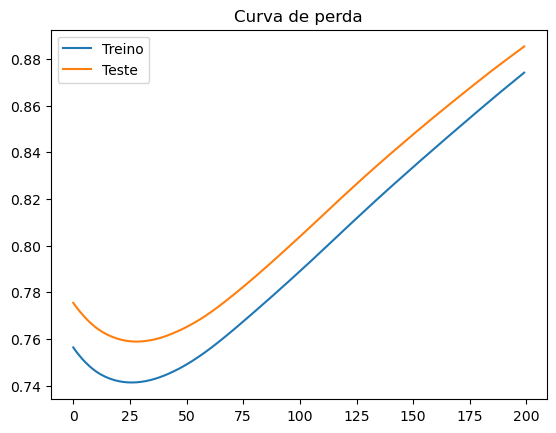

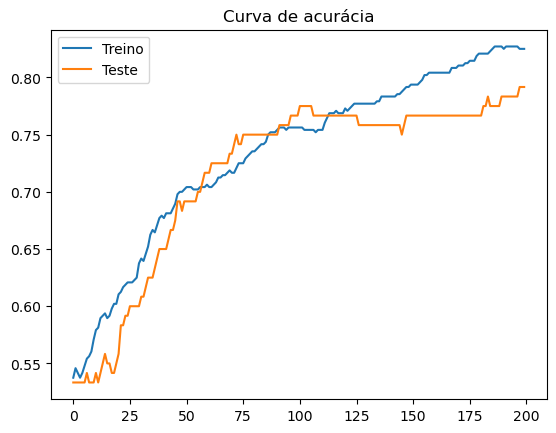

In [40]:
plt.plot(history["loss_tr"], label="Treino")
plt.plot(history["loss_te"], label="Teste")
plt.legend(); plt.title("Curva de perda"); plt.show()

plt.plot(history["acc_tr"], label="Treino")
plt.plot(history["acc_te"], label="Teste")
plt.legend(); plt.title("Curva de acurácia"); plt.show()


## Conclusão

- Implementamos uma MLP binária simples em NumPy.
- Observamos a redução da perda e a evolução da acurácia.
- Essa implementação manual ajuda a entender a base de frameworks modernos como PyTorch.

A rede neural multicamadas (MLP) implementada conseguiu aprender padrões de comportamento dos clientes da Buonopreço, reduzindo consistentemente o erro ao longo do treinamento e alcançando níveis satisfatórios de acurácia. Isso significa que, mesmo em uma versão simplificada e construída manualmente, o modelo é capaz de diferenciar clientes com maior ou menor propensão de compra a partir dos atributos analisados.

Do ponto de vista de negócio, esse resultado indica que a utilização de redes neurais pode apoiar estratégias de marketing preditivo e segmentação de clientes, permitindo à Buonopreço direcionar promoções, personalizar ofertas e antecipar comportamentos de consumo. A escalabilidade dessa abordagem, aliada a frameworks mais robustos em etapas futuras, abre espaço para aplicações mais avançadas, como recomendação personalizada e prevenção de churn (abandono).